# IMPORTS

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder 
import warnings
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# READING DATA

In [2]:
df = pd.read_csv('C:/Users/hazem/Desktop/Level 7/data/aqardata_2.csv')
xd = df[['streetwidth', 'size']]
yd = df.Pricepm

In [3]:
df.head()

,mainlocation,sublocation,neighborhood,frontage,purpose,streetwidth,size,Pricepm
0,الرياض,غرب الرياض,حي ظهرة لبن,شمال,سكني,20.0,727,1800
1,بريدة,NaN,حي مشعل,غرب,NaN,15.0,450,950
2,الخبر,NaN,حي الحمرا,غرب,تجاري,100.0,1450,3500
3,الخبر,NaN,حي الحزام الاخضر,شرق,NaN,15.0,440,2700
4,بريدة,NaN,حي الرحاب,جنوب غربي,NaN,40.0,784,950


## data visualization
We will analyze the data to handle missing data and imbalance data

In [4]:
df.describe()

,streetwidth,size,Pricepm
count,2948.000000,2.951000e+03,2951.000000
mean,24.691995,1.040184e+04,2624.025754
std,15.208720,2.033230e+05,2970.544618
min,1.000000,8.100000e+01,1.000000
25%,15.000000,5.750000e+02,1200.000000
50%,20.000000,8.250000e+02,2600.000000
75%,30.000000,1.350000e+03,3500.000000
max,100.000000,1.000000e+07,83333.000000


In [5]:
uniques = {col: df[col].unique() for col in df.columns}
uniques_df = pd.DataFrame(uniques.items(), columns = ['col_name', 'unique_values'])

pd.set_option('display.max_colwidth', None)
uniques_df

,col_name,unique_values
0,mainlocation,"[الرياض, بريدة, الخبر, جدة, سكاكا, الجموم, المدينة المنورة, الدمام, مكة المكرمة, عرعر, عنيزة, خميس مشيط, الدرعية, المزاحمية, الزلفي, جازان, الدلم, ثول, الخرج, الرس, رابغ, الهفوف, احد رفيده, ابها, صامطة, ثادق, الهياثم, الظهران, القطيف, الطائف, بيش, صبيا, ابو عريش, مدينة الملك عبدالله الاقتصادية, رماح, تبوك, نجران, المجمعة, الشنان, حائل, رياض الخبراء, النبهانية, صفوى, تاروت, المذنب]"
1,sublocation,"[غرب الرياض, nan, شمال الرياض, شمال جدة, جنوب الرياض, شرق الرياض, جنوب جدة, وسط الرياض]"
2,neighborhood,"[حي ظهرة لبن, حي مشعل, حي الحمرا, حي الحزام الاخضر, حي الرحاب, حي العارض, حي الريان, حي مخطط كريم الدرزي, حي النسيم, حي الخالدية, حي القصيعة, حي السلي, حي اشبيلية, حي الزهراء, حي الغابة, حي الشرق, حي طيبة, حي القيروان, حي الراشدية, حي النرجس, حي صلاح الدين, حي الصالحية, حي العريمضي, حي الورود, حي ابو بريقاء, حي الصفا, حي السكب, حي العكيشية, حي المشاعل, حي الخليج, حي الغنامية, حي الربيع, حي الشقة, حي الجصة, حي بنبان, حي مخطط المنح الخاصة, حي خب الكيفة, حي الدرعية الجديدة, حي الغطغط, حي العزيزية, حي اليرموك, حي الرمال, حي الروضة, حي الدفاع, حي اللؤلؤ, حي الصوارى, حي عرقة, حي الملز, حي الشفاء, حي الحمراء, حي طويق, حي البلقاء, حي النقع الشرقية, حي ضاحية نمار, حي المصفاة, حي الندى, حي الروابي, حي قرطبة, حي الدار البيضاء, حي الياقوت, حي الصواري, حي الخزامى, حي الرياض, حي القادسية, حي حطين, حي الملقا, حي المهدية, حي الصحافة, حي المرجان, حي الياسمين, حي المونسية, حي العقيق, حي التحلية, حي السلام, حي الكوثر, حي السعادة, حي عكاظ, حي السليمانية, حي الرجاء, حي الزمرد, حي ثول, حي مشرف, حي العليا, حي السيف, حي الفلاح, حي النخيل, حي الوادي, حي الحزم, حي الشراع, حي الملك عبدالله, حي ظهرة نمار, حي المروة, حي الحزام الذهبي, حي الغليل, حي الرحمانية, حي عريض, حي الجامعيين, حي الجنادرية, حي المحمدية, حي المروج, ...]"
3,frontage,"[شمال, غرب, شرق, جنوب غربي, جنوب, شمال غربي, 3 شوارع, جنوب شرقي, 4 شوارع, شمال شرقي]"
4,purpose,"[سكني, nan, تجاري, سكني أو تجاري, غير محدد]"
5,streetwidth,"[20.0, 15.0, 100.0, 40.0, 60.0, 35.0, 25.0, 80.0, 30.0, 55.0, 10.0, 46.0, 16.0, 36.0, 32.0, 18.0, 19.0, 61.0, 28.0, 85.0, 12.0, 38.0, 5.0, 37.0, 14.0, 24.0, 50.0, 64.0, 31.0, 21.0, 6.0, 11.0, 45.0, 27.0, nan, 13.0, 22.0, 65.0, 17.0, 53.0, 1.0, 84.0, 52.0, 29.0]"
6,size,"[727, 450, 1450, 440, 784, 5973, 660, 735, 153500, 591, 400, 3200, 743, 600, 7322, 840, 1818, 1800, 3000, 12370, 525, 3250, 805, 500, 4160, 1640, 1050, 1000, 632, 7222, 325, 480, 3600, 750, 437, 889, 2610000, 720, 639, 975, 2000, 375, 640, 13200, 2560, 14570, 14840, 636, 878, 2200, 900, 439, 1200, 4980, 613, 546, 575, 580, 433, 2500, 435, 244137, 998, 870, 360, 45000, 875, 1128, 300, 81, 556, 899, 6650, 1575, 6400, 747, 21563, 490, 402, 1025, 1087, 625, 6128, 700, 337, 982, 770, 312, 446, 644, 829, 441, 790, 345, 420, 1055, 343, 1030, 1680, 3680, ...]"
7,Pricepm,"[1800, 950, 3500, 2700, 2000, 2300, 219, 195, 5076, 235, 1500, 2500, 5333, 1502, 300, 2900, 1666, 550, 2200, 10000, 161, 330, 9500, 4000, 333, 2150, 1000, 750, 2615, 350, 1660, 466, 240, 101, 236, 60, 1100, 282, 2800, 505, 1950, 274, 900, 1667, 500, 478, 3000, 440, 280, 1150, 430, 501, 1379, 480, 3600, 2659, 1690, 2250, 20, 1250, 695, 2280, 4100, 4500, 2400, 1400, 3900, 1097, 630, 3300, 4200, 2450, 3700, 870, 2350, 3800, 4300, 909, 1900, 1240, 844, 3100, 700, 1014, 3400, 2912, 446, 1750, 255, 7500, 8000, 2100, 285, 359, 4400, 780, 3200, 2850, 535, 1300, ...]"


In [6]:
df.isnull().sum()

mainlocation      0
sublocation     675
neighborhood      0
frontage          0
purpose         347
streetwidth       3
size              0
Pricepm           0
dtype: int64

## Handling missing data
we can clearly that the data has more than 675 missing value
dropping the value would be a waste since our data set is not so big
we will handle the missing data as follow.

- Sublocation:
we will forward fill mainlocation as a sublocation, the reason is that we want to create a relation only to between the same location instead of creating a relation between other location.

- Purpose: 
since there is an unknow category 'غير محدد' we are gonna fill empty purpose with 'غير محدد'

- Streetwidth:
since the missing values are just 3, it's easier to drop them.

In [7]:
#droping streetwidth
df1 = df.dropna(how = 'any', subset= ['streetwidth'])

#filling 'غير محدد' on purpose 
df2 =df1.fillna({
    'purpose' : 'غير محدد'})

#forwardfilling sublocation 
df3 = df2.fillna(method = 'ffill', axis = 'columns', limit= 1)

#seeing the null values
df3.isnull().sum()

mainlocation    0
sublocation     0
neighborhood    0
frontage        0
purpose         0
streetwidth     0
size            0
Pricepm         0
dtype: int64

## Handling outliers and imbalanced data
We will visualize and handle the outlier, first let's visualize the data

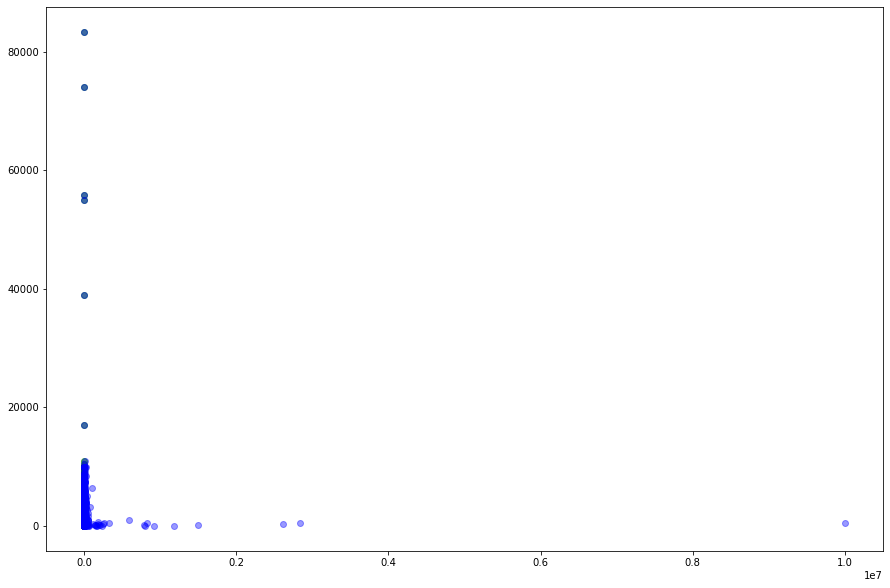

In [8]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)
plt.scatter(df3['streetwidth'], df3['Pricepm'], color = 'g', alpha=0.6)
plt.scatter(df3['size'], df3['Pricepm'], color = 'b', alpha=0.4)

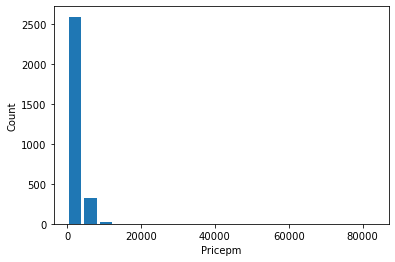

In [9]:
plt.hist(df3.Pricepm, bins=20, rwidth=0.8)
plt.xlabel('Pricepm')
plt.ylabel('Count')
plt.show()

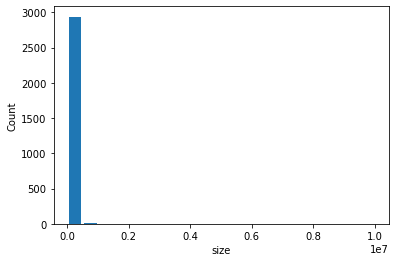

In [10]:
plt.hist(df3['size'], bins=20, rwidth=0.8)
plt.xlabel('size')
plt.ylabel('Count')
plt.show()

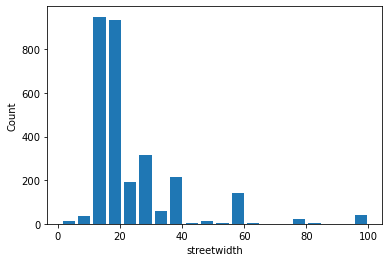

In [11]:
plt.hist(df3['streetwidth'], bins=20, rwidth=0.8)
plt.xlabel('streetwidth')
plt.ylabel('Count')
plt.show()

<AxesSubplot:xlabel='mainlocation', ylabel='count'>

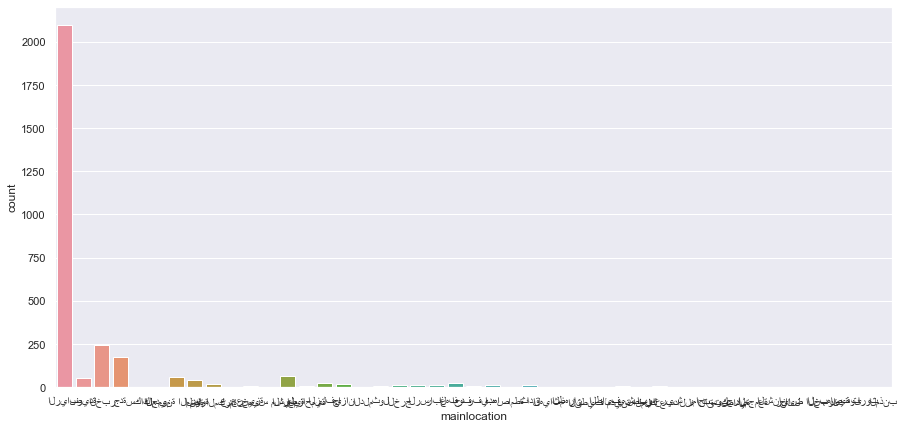

In [12]:
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(x= df3.mainlocation)

<AxesSubplot:xlabel='sublocation', ylabel='count'>

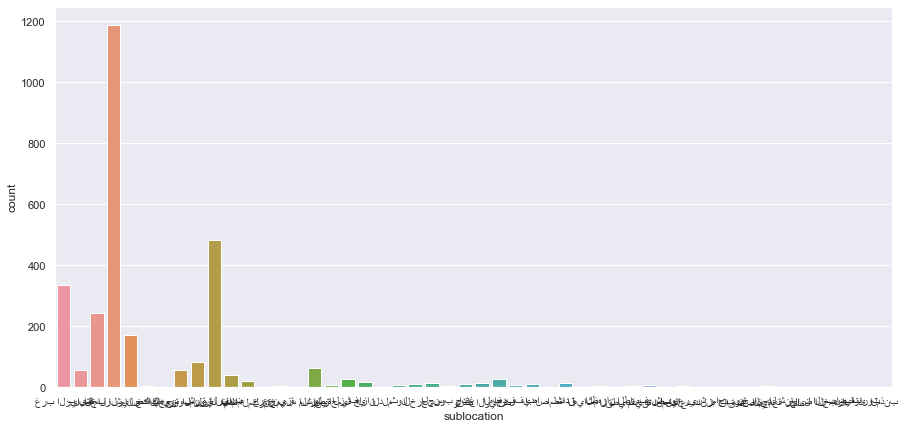

In [13]:
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(x= df3.sublocation)

We can see that the data is imbalance, and has a lot of outlier.
to handle that we will do the following:

- Handle outlier:
we will use IQR to detect and remove outlier.
- handling imbalace data
we will try to palance the sublocation column, and add a weight for the imbalance value.

In [14]:
Q1_size = df3['size'].quantile(0.10)
Q3_size = df3['size'].quantile(0.70)
IQR_size = Q3_size - Q1_size
lower_limit_size = Q1_size - 1.5*IQR_size
upper_limit_size = Q3_size + 1.5*IQR_size
Q1_pricepm = df3['Pricepm'].quantile(0.05)
Q3_pricepm = df3['Pricepm'].quantile(0.45)
IQR_pricepm = Q3_pricepm - Q1_pricepm
lower_limit_price = Q1_pricepm - 1.5*IQR_pricepm
upper_limit_price = Q3_pricepm + 1.5*IQR_pricepm
Q1_sw = df3['streetwidth'].quantile(0.10)
Q3_sw = df3['streetwidth'].quantile(0.72)
IQR_sw = Q3_sw - Q1_sw
lower_limit_sw = Q1_sw - 1.5*IQR_sw
upper_limit_sw = Q3_sw + 1.5*IQR_sw




df3 = df3[(df3['size'] > lower_limit_size) &(df3['size'] < upper_limit_size)
                   &(df3['streetwidth']>lower_limit_sw)&(df3['streetwidth']<upper_limit_sw)
                   &(df3['Pricepm']>lower_limit_price)&(df3['Pricepm']<upper_limit_price)]

In [15]:
df3.shape

(2255, 8)

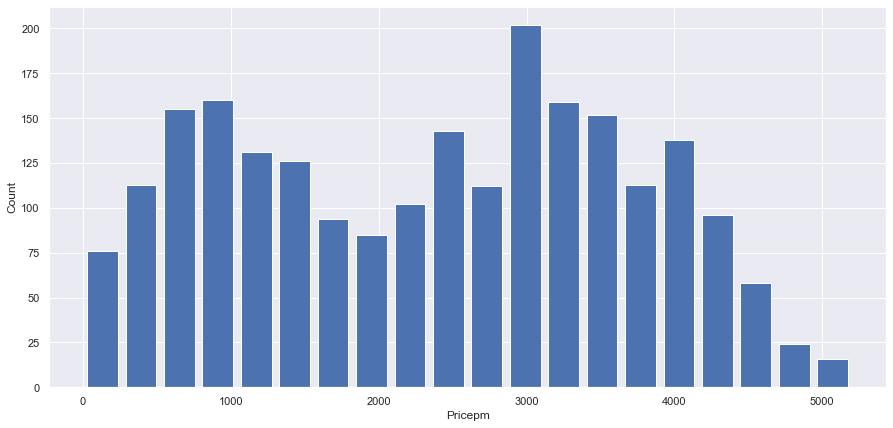

In [16]:
plt.hist(df3.Pricepm, bins=20, rwidth=0.8)
plt.xlabel('Pricepm')
plt.ylabel('Count')
plt.show()

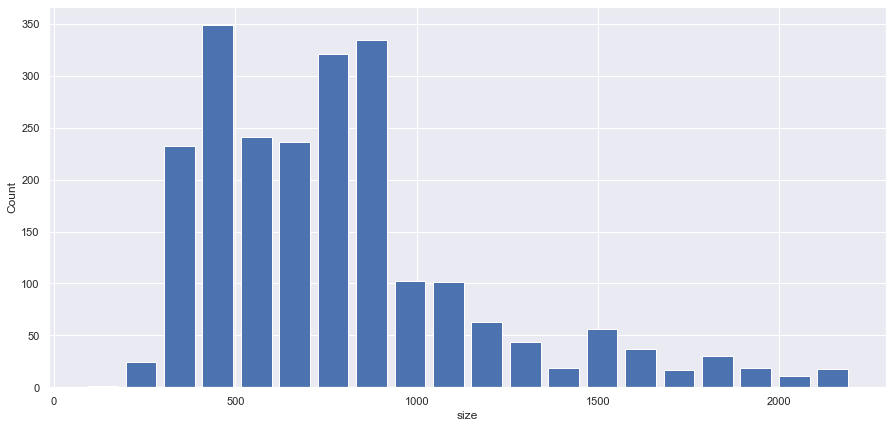

In [17]:
plt.hist(df3['size'], bins=20, rwidth=0.8)
plt.xlabel('size')
plt.ylabel('Count')
plt.show()

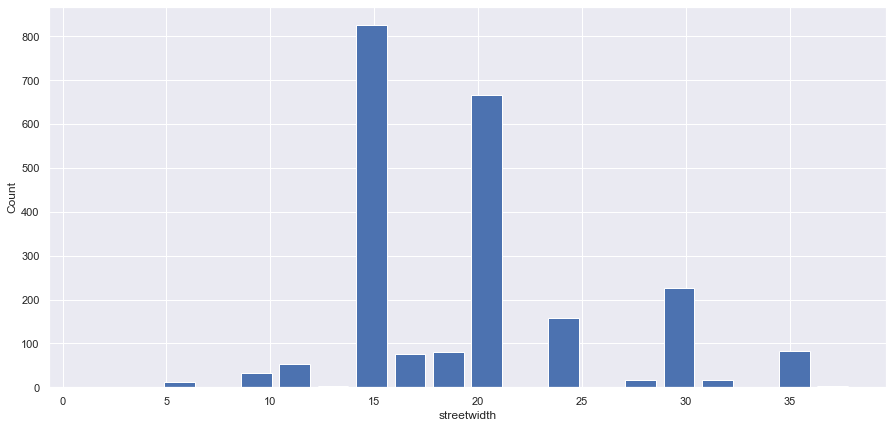

In [18]:
plt.hist(df3['streetwidth'], bins=20, rwidth=0.8)
plt.xlabel('streetwidth')
plt.ylabel('Count')
plt.show()

In [19]:
df3['sublocation'].value_counts()

شمال الرياض                       921
شرق الرياض                        383
غرب الرياض                        264
الخبر                             172
شمال جدة                          140
جنوب الرياض                        57
بريدة                              47
الدرعية                            42
المدينة المنورة                    35
الدمام                             25
الهفوف                             23
الزلفي                             23
جازان                              13
ثادق                               12
مكة المكرمة                        12
ابها                               11
الرس                               10
رابغ                               10
الخرج                               9
وسط الرياض                          8
ثول                                 5
احد رفيده                           4
عنيزة                               3
ابو عريش                            3
الظهران                             3
سكاكا                               3
تبوك        

In [20]:
df3.loc[(df3['sublocation']!= 'شمال الرياض') & (df3['sublocation']!= 'غرب الرياض')&
        (df3['sublocation']!= 'الخبر') & (df3['sublocation']!= 'شمال جدة')
        &(df3['sublocation']!= 'الدرعية') & (df3['sublocation']!= 'الدمام')
        &(df3['sublocation']!= 'بريدة') & (df3['sublocation']!= 'المدينة المنورة')
        &(df3['sublocation']!= 'الهفوف') & (df3['sublocation']!= 'الزلفي')
        &(df3['sublocation']!= 'ثادق') & (df3['sublocation']!= 'مكة المكرمة'),
       'sublocation'] =  'اخرى'

df3.loc[df3['sublocation'] != 'شمال الرياض', 'In Riyadh'] = 'no'
df3.loc[df3['sublocation'] == 'شمال الرياض', 'In Riyadh'] = 'yes'

In [21]:
df3['sublocation'].value_counts()

شمال الرياض        921
اخرى               539
غرب الرياض         264
الخبر              172
شمال جدة           140
بريدة               47
الدرعية             42
المدينة المنورة     35
الدمام              25
الزلفي              23
الهفوف              23
مكة المكرمة         12
ثادق                12
Name: sublocation, dtype: int64

<AxesSubplot:xlabel='sublocation', ylabel='count'>

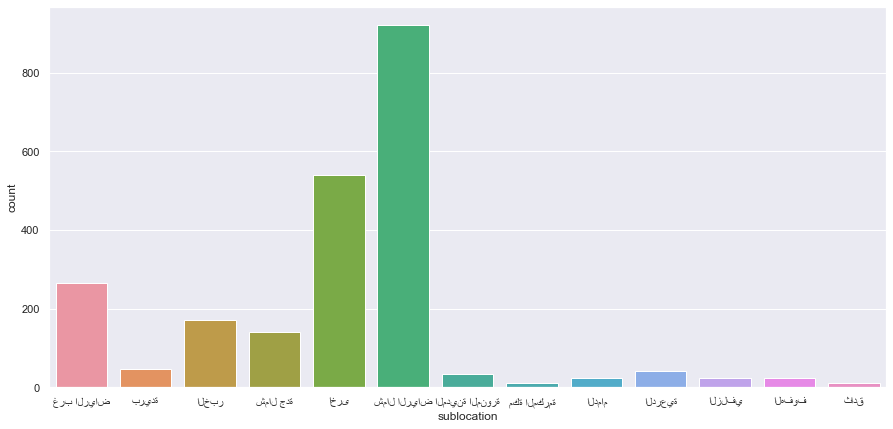

In [22]:
sns.set(rc={'figure.figsize':(15,7)})
sns.countplot(x= df3.sublocation)

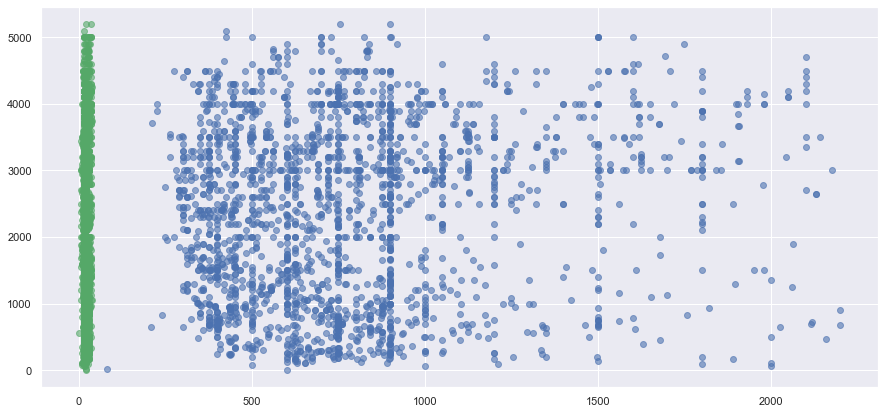

In [23]:
plt.scatter(df3['streetwidth'], df3['Pricepm'], color = 'g', alpha=0.6)
plt.scatter(df3['size'], df3['Pricepm'], color = 'b', alpha=0.6)

We can see that the data now has a better ditribution and no outlier

## Data spliting 
we will splitt the data and one-hot-encode all categorical data

In [24]:
x = df3.drop(['Pricepm'], axis = 'columns')
y = df3.Pricepm

ohe = OneHotEncoder(sparse=False)

ct = make_column_transformer(
    (ohe, ['mainlocation','sublocation','neighborhood','frontage',
           'purpose' , 'In Riyadh' ]),
    remainder='passthrough')

x = ct.fit_transform(x)
y = y.astype('int')

## Parameter tuning
I decided to use RandomForest as my algorithm, it gave me a good and consistent resuls.
After experimenting with parameter, defualt parameters worked the best, the more number of estimators we got the better the accuracy.

## Scaling 
After testing some scaling algorithms, the result didn't get any better, so i decided not to use any scalers.

## Test results

In [34]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1 ,random_state= 0, n_estimators = 5000)

In [33]:
scores = cross_val_score(rf, x, y, cv=5, scoring='neg_root_mean_squared_error')
print(scores)

average=0
for i in scores:
    average = i + average

print('average: ' , abs(average/5))

[-420.00513615 -437.21129378 -407.38729432 -458.34746975 -459.49796703]
average:  436.48983220755815


In [35]:
scores = cross_val_score(rf, x, y, cv=5, scoring='neg_mean_absolute_error')
print(scores)
average=0
for i in scores:
    average = i + average
    
print('average: ' , abs(average/5))

[-270.75511677 -273.86816725 -243.13890509 -283.65957399 -287.78183472]
average:  271.84071956233475


In [36]:
scores = cross_val_score(rf, x, y, cv=5, scoring='r2')
print(scores)

average=0
for i in scores:
    average = i + average
    
print('average: ' , abs(average/5))

[0.90267903 0.88657754 0.90262749 0.86867339 0.87362037]
average:  0.8868355640211985
